# Aperiodic and oscillatory components of the power spectrum

This notebook demonstrates how to use YASA to separate the aperiodic (= fractal = $1/f$) components of the EEG power spectra using the IRASA method.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import mne
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.2)

## Data loading

Let's load 6 min of eyes open EEG data, sampled at 200 Hz. We use the [MNE library](https://mne.tools/stable/index.html), which includes various functions and utilities for reading EEG data and electrode locations. For a description of all the file formats supported by MNE, please refer to https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html

Note that during loading, MNE automatically scale the EEG data from microVolts (uV) to Volts. However, YASA requires the data to be in microVolts (uV), and therefore we need to reverse this scaling by multiplying our data by 1e6 (1 V = 1,000,000 uV).

In [2]:
# Load data as a MNE Raw file
raw = mne.io.read_raw_fif('data_resting_EO_200Hz_raw.fif', preload=True, verbose=0)

# Extract data, sf, and chan
data = raw.get_data() * 1e6  # Convert data from V to uV
sf = raw.info['sfreq']
chan = raw.ch_names

# Let's have a look at the data
print('Chan =', chan)
print('Sampling frequency =', sf, 'Hz')
print('Data shape =', data.shape)
print('Duration =', data.shape[1] / sf, 'seconds')

Chan = ['F4-A1', 'CZ-A2']
Sampling frequency = 200.0 Hz
Data shape = (2, 72000)
Duration = 360.0 seconds


**************

## Calculate the original power spectrum

For a primer on EEG spectral power please refer to https://raphaelvallat.com/bandpower.html or [08_bandpower.ipynb](08_bandpower.ipynb)

(401,) (2, 401)


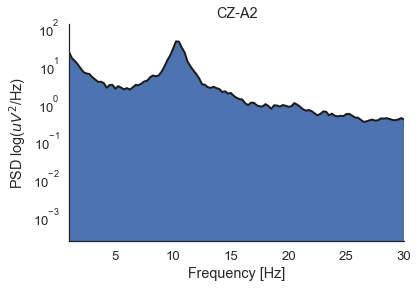

In [3]:
from scipy.signal import welch

win = int(4 * sf)  # Window size is set to 4 seconds
freqs, psd = welch(data, sf, nperseg=win)  # Works with single or multi-channel data

print(freqs.shape, psd.shape)  # psd has shape (n_channels, n_frequencies)

# Plot
plt.plot(freqs, psd[1, :], 'k', lw=2)
plt.fill_between(freqs, psd[1, :], cmap='Spectral')
plt.xlim(1, 30)
plt.yscale('log')
sns.despine()
plt.title(chan[1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)');

As can be seen on the plot above, there is a strong alpha oscillatory peak around 10-11 Hz.

## Extract the aperiodic and periodic component of the spectrum

The Irregular-Resampling Auto-Spectral Analysis (IRASA) method ([Wen & Liu 2016](https://doi.org/10.1007/s10548-015-0448-0)) allows to separate the
fractal and oscillatory components in the power spectrum of EEG signals.

The steps are:

1. Compute the original power spectral density (PSD).
2. Resample the EEG data by multiple non-integer factors and their
reciprocals ($h$ and $1/h$).
3. For every pair of resampled signals, calculate the PSD and take the
geometric mean of both. In the resulting PSD, the power associated with the
oscillatory component is redistributed away from its original
(fundamental and harmonic) frequencies by a frequency offset that varies
with the resampling factor, whereas the power solely attributed to the
fractal component remains the same power-law statistical distribution
independent of the resampling factor.
4. It follows that taking the median of the PSD of the variously
resampled signals can extract the power spectrum of the fractal component,
and the difference between the original power spectrum and the extracted
fractal spectrum offers an approximate estimate of the power spectrum of
the oscillatory component.

**For more details on the IRASA method, please refer to**

- Wen, H., & Liu, Z. (2016). Separating Fractal and Oscillatory Components in the Power Spectrum of Neurophysiological Signal. Brain Topography, 29(1), 13–26. https://doi.org/10.1007/s10548-015-0448-0
- https://github.com/fieldtrip/fieldtrip/blob/master/specest/

**For another method to extract fractal noise, please refer to**
- https://github.com/fooof-tools/fooof
- https://www.biorxiv.org/content/10.1101/299859v1

In [4]:
# Apply the IRASA technique
freqs, psd_aperiodic, psd_osc = yasa.irasa(data, sf, ch_names=chan, band=(1, 30), win_sec=4, return_fit=False)

29-Oct-21 15:21:51 | WARNING | The evaluated frequency range ends after the resampled Nyquist frequency (52.63Hz). Decrease the upper band (30.00Hz) or decrease the maximum value of the hset (1.90).


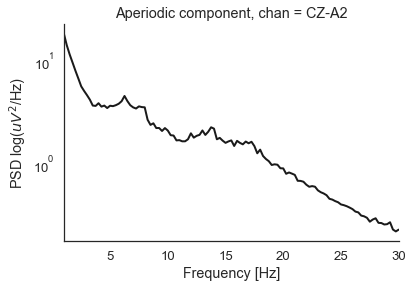

In [5]:
# Plot the aperiodic component on a linear-log scale
plt.plot(freqs, psd_aperiodic[1, :], 'k', lw=2)
plt.xlim(1, 30)
plt.yscale('log')
sns.despine()
plt.title('Aperiodic component, chan = ' + chan[1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)');

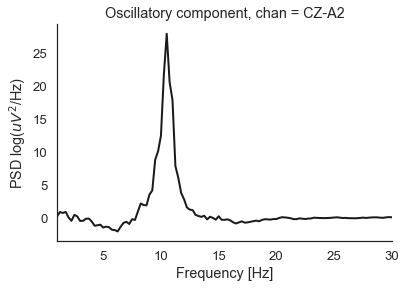

In [6]:
# Plot the oscillatory component on a linear-linear scale
plt.plot(freqs, psd_osc[1, :], 'k', lw=2)
plt.xlim(1, 30)
sns.despine()
plt.title('Oscillatory component, chan = ' + chan[1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD log($uV^2$/Hz)');

In [7]:
# Plot the oscillatory + aperiodic component on a linear-log scale
# psd_combined = psd_aperiodic[1, :] + psd_osc[1, :]
# plt.plot(freqs, psd_combined, 'k', lw=2)
# plt.fill_between(freqs, psd_combined, cmap='Spectral')
# plt.xlim(1, 30)
# plt.yscale('log')
# sns.despine()
# plt.title('Aperiodic + oscillatory component, chan = ' + chan[1])
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('PSD log($uV^2$/Hz)');

## Fit the fractal component (1/f)

If `return_fit=True` (default), `yasa.irasa` [fits an exponential function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to the aperiodic power spectrum and return the fit parameters (intercept, slope), the $R^2$ of the fit, and the standard deviation of the oscillatory component.

The aperiodic signal, $L$, is modeled using an exponential function in semilog-power space (linear frequencies and log PSD) as:

$L = a + log(F^b)$

where $a$ is the intercept, $b$ is the slope, and $F$ the vector of input frequencies.

In [8]:
freqs, psd_aperiodic, psd_osc, fit_params = yasa.irasa(data, sf, ch_names=chan)
fit_params

29-Oct-21 15:21:51 | WARNING | The evaluated frequency range ends after the resampled Nyquist frequency (52.63Hz). Decrease the upper band (30.00Hz) or decrease the maximum value of the hset (1.90).
/Users/raphael/GitHub/yasa/yasa/spectral.py:567: RuntimeWarning: divide by zero encountered in reciprocal
  return a + np.log(t**b)


,Chan,Intercept,Slope,R^2,std(osc)
0,F4-A1,3.351799,-1.297857,0.961306,1.012285
1,CZ-A2,3.272062,-1.192108,0.855980,4.525508
